In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


from src.data.datasets import ModelDataset
from src.model.models import DWSModelForClassification
from src.data.generators import generate_splits, compute_stats
from src.data.evaluation import evaluate_dwsnets

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

## Train

In [61]:
generate_splits("../../models/zoo_big/", "../../data/", total_size=10000, val_size=1000, test_size=8900)
compute_stats("../../data/dataset_splits.json", "../../data/", batch_size=800)

In [64]:
path = "../../data/dataset_splits.json"
statistics_path = "../../data/statistics.pth"
normalize = True
batch_size = 512
num_workers = 4

train_set = ModelDataset( path=path, split="train", normalize=normalize, statistics_path=statistics_path)
val_set = ModelDataset( path=path, split="val", normalize=normalize, statistics_path=statistics_path)
test_set = ModelDataset( path=path, split="test", normalize=normalize, statistics_path=statistics_path)


train_loader = torch.utils.data.DataLoader( dataset=train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = torch.utils.data.DataLoader( dataset=val_set, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = torch.utils.data.DataLoader( dataset=test_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

print(f"train size {len(train_set)}")
print(f"val size {len(val_set)}")
print(f"test size {len(test_set)}")

point = train_set.__getitem__(0)
print([w.shape for w in point.weights])
print([b.shape for b in point.biases])
weight_shapes = tuple(w.shape[:2] for w in point.weights)
bias_shapes = tuple(b.shape[:1] for b in point.biases)

train size 800
val size 8000
test size 71200


In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DWSModelForClassification(
    weight_shapes=weight_shapes,
    bias_shapes=bias_shapes,
    input_features=1,
    hidden_dim=32,
    n_hidden=4,
    n_classes=8,
    bn=True,
).to(device)

optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3, amsgrad=True, weight_decay=5e-4)

  0%|          | 0/10 [00:00<?, ?it/s]

train size 80
val size 80
test size 79840


  0%|          | 0/100 [00:00<?, ?it/s]

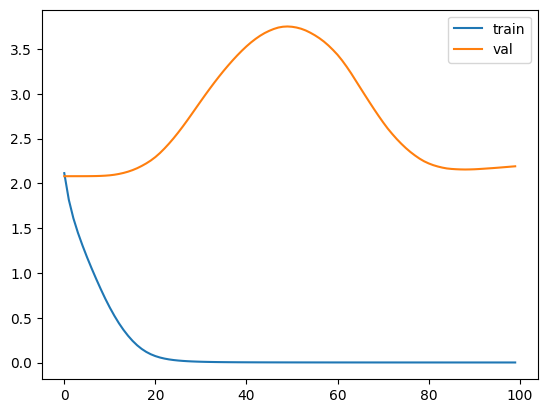

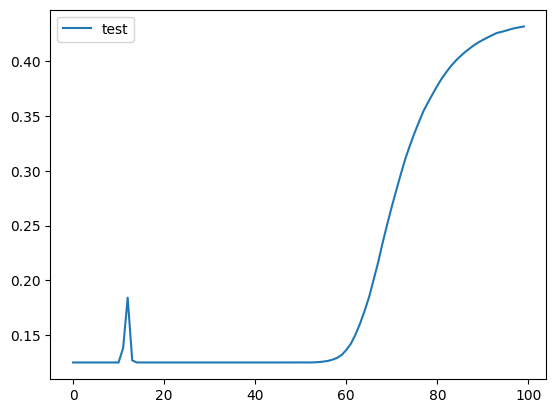

train size 800
val size 800
test size 78400


  0%|          | 0/100 [00:00<?, ?it/s]

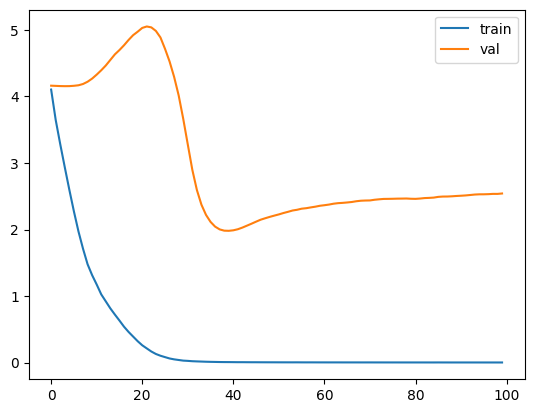

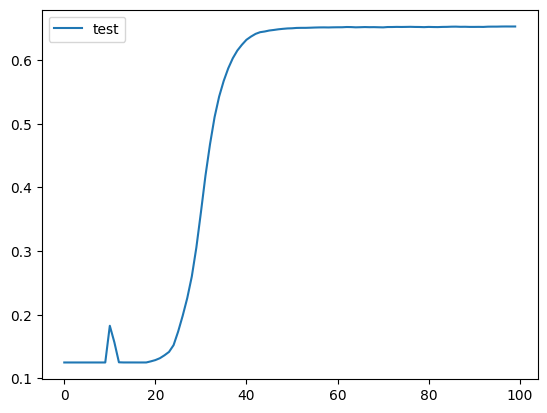

train size 1600
val size 1600
test size 76800


  0%|          | 0/100 [00:00<?, ?it/s]

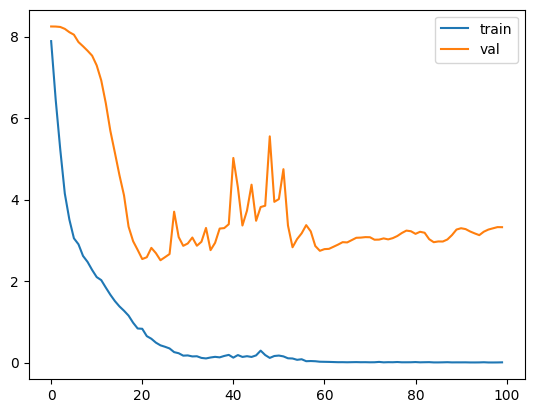

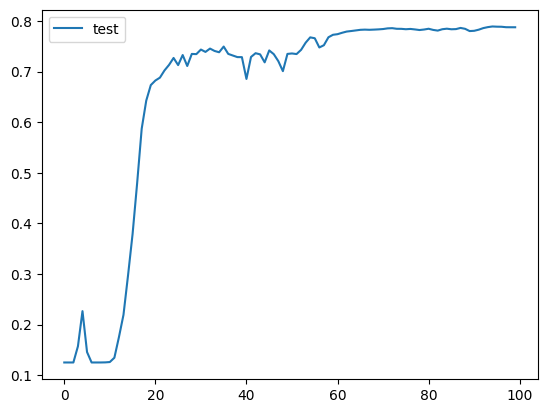

train size 4000
val size 4000
test size 72000


  0%|          | 0/100 [00:00<?, ?it/s]

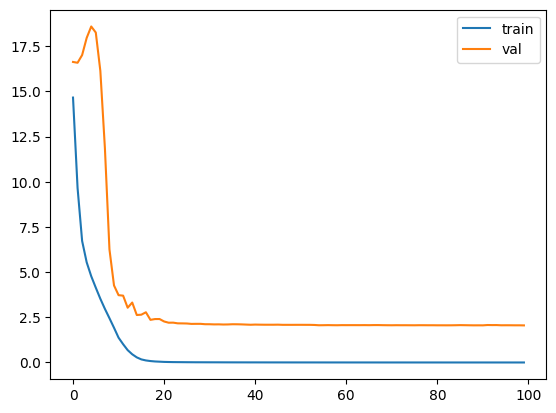

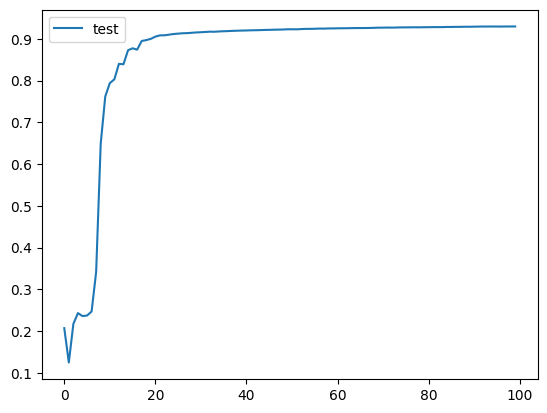

train size 8000
val size 8000
test size 64000


  0%|          | 0/100 [00:00<?, ?it/s]

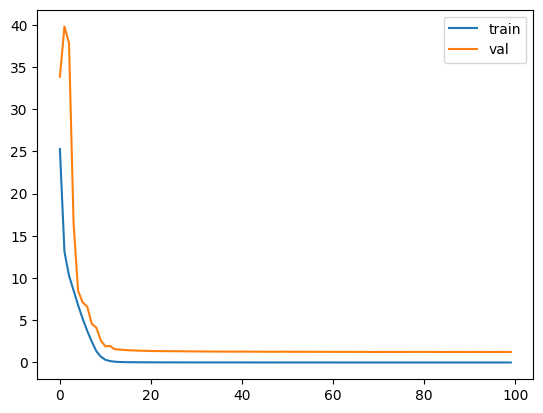

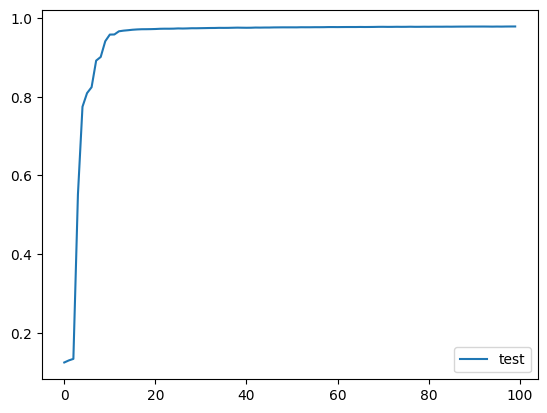

train size 16000
val size 16000
test size 48000


  0%|          | 0/100 [00:00<?, ?it/s]

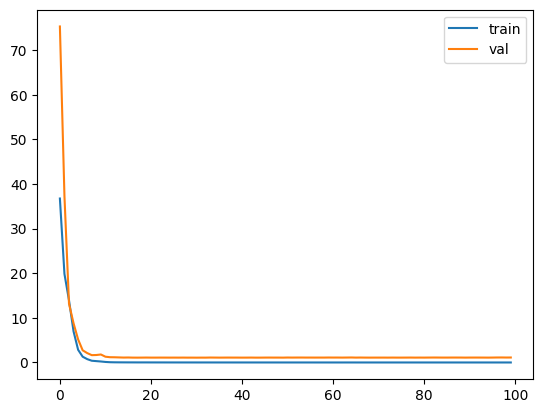

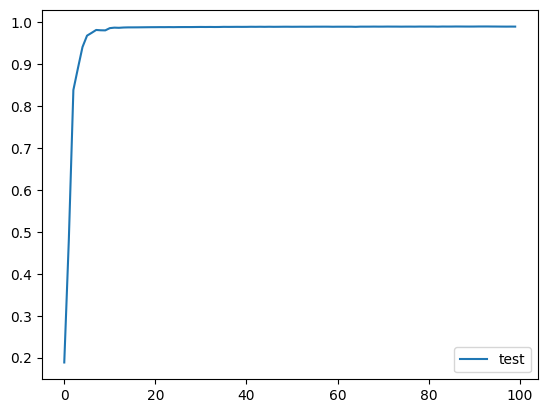

train size 40000
val size 24000
test size 16000


  0%|          | 0/100 [00:00<?, ?it/s]

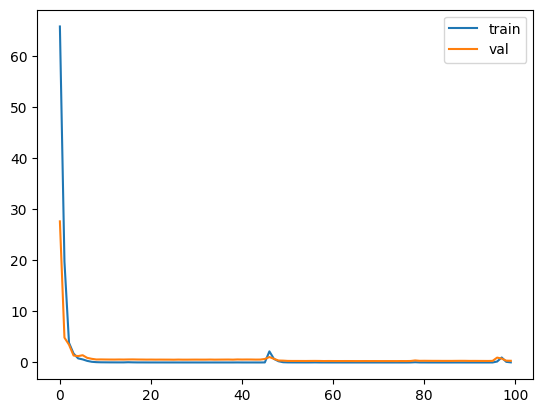

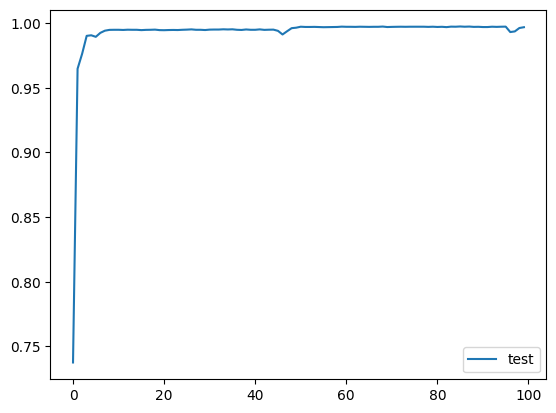

train size 56000
val size 16000
test size 8000


  0%|          | 0/100 [00:00<?, ?it/s]

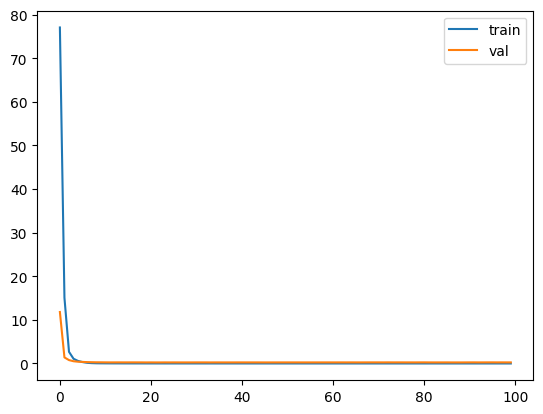

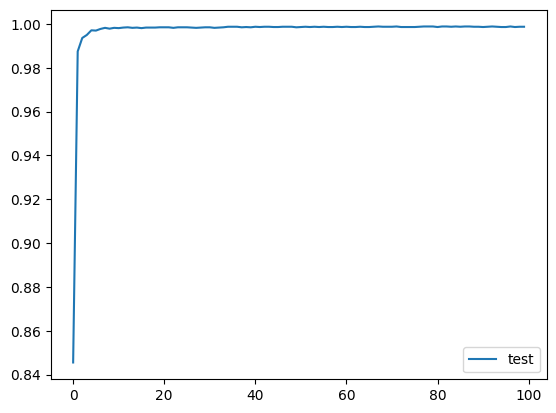

train size 64000
val size 8000
test size 8000


  0%|          | 0/100 [00:00<?, ?it/s]

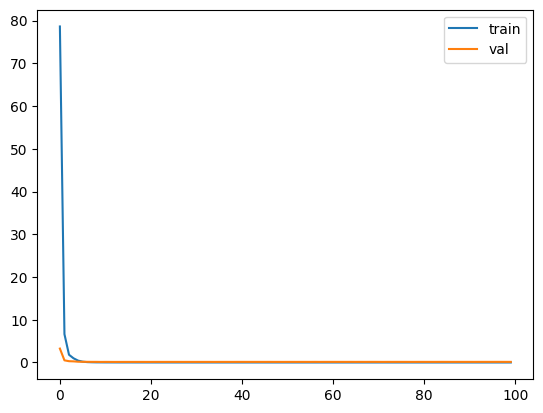

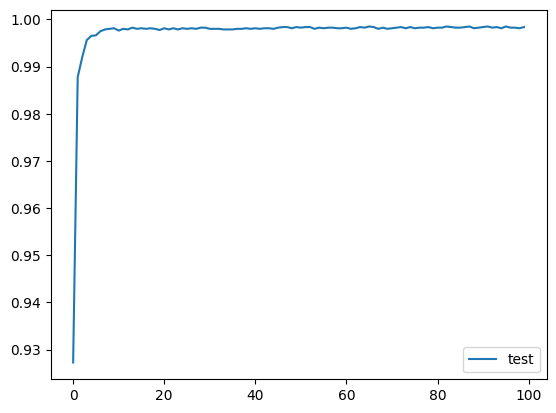

train size 72000
val size 4000
test size 4000


  0%|          | 0/100 [00:00<?, ?it/s]

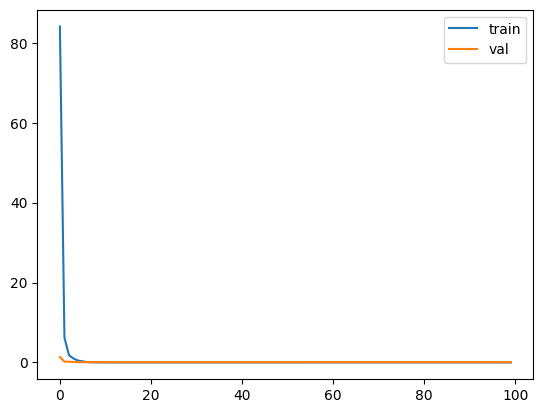

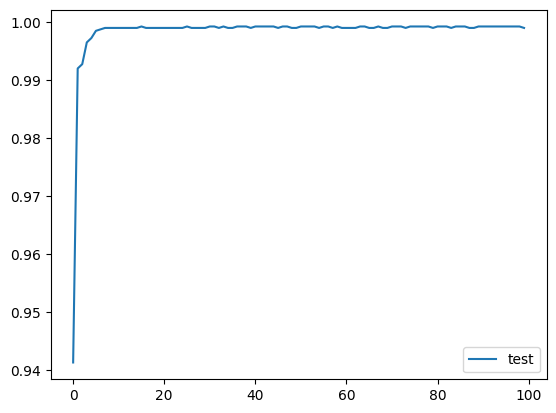

In [76]:
epochs = 100
criterion = nn.CrossEntropyLoss()
test_acc = -1

# Dataset 
path = "../../data/dataset_splits.json"
statistics_path = "../../data/statistics.pth"
normalize = True
batch_size = 512
num_workers = 4

test_accuracies_progress = []

for train_size in tqdm([[0.001, 0.001, 0.998], [0.01, 0.01, 0.98], [0.02, 0.02, 0.96], [0.05, 0.05, 0.9], [0.1, 0.1, 0.8], [0.2, 0.2, 0.6], [0.5, 0.3, 0.2], [0.7, 0.2, 0.1], [0.8, 0.1, 0.1], [0.9, 0.05, 0.05]]):
    train_dataset_size = train_size[0] * 10000
    val_dataset_size = train_size[1] * 10000
    test_dataset_size = train_size[2] * 10000
    generate_splits("../../models/zoo_big/", "../../data/", total_size=10000, val_size=val_dataset_size, test_size=test_dataset_size, name=f"dataset_splits_{train_dataset_size}_{val_dataset_size}_{test_dataset_size}.json")
    compute_stats("../../data/dataset_splits.json", "../../data/", batch_size=int(train_dataset_size)*8, name = f"statistics_{train_dataset_size}_{val_dataset_size}_{test_dataset_size}.json")    

    train_set = ModelDataset( path=path, split="train", normalize=normalize, statistics_path=statistics_path)

    val_set = ModelDataset( path=path, split="val", normalize=normalize, statistics_path=statistics_path)

    test_set = ModelDataset( path=path, split="test", normalize=normalize, statistics_path=statistics_path)


    train_loader = torch.utils.data.DataLoader( dataset=train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = torch.utils.data.DataLoader( dataset=val_set, batch_size=batch_size, num_workers=num_workers, shuffle=False)
    test_loader = torch.utils.data.DataLoader( dataset=test_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

    print(f"train size {len(train_set)}")
    print(f"val size {len(val_set)}")
    print(f"test size {len(test_set)}")
    

    model = DWSModelForClassification( weight_shapes=weight_shapes, bias_shapes=bias_shapes, input_features=1, hidden_dim=32, n_hidden=4, n_classes=8, bn=True).to(device)

    optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3, amsgrad=True, weight_decay=5e-4)

    train_losses = []
    val_losses = []
    test_accuracies = []

    for epoch in tqdm(range(epochs)):
        total_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()

            batch = batch.to(device)
            inputs = (batch.weights, batch.biases)
            out = model(inputs)

            loss = criterion(out, batch.label)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        train_losses.append(total_loss)
        total_loss = 0
        model.eval()
        for batch in val_loader:
            batch = batch.to(device)
            inputs = (batch.weights, batch.biases)
            out = model(inputs)
            loss = criterion(out, batch.label)
            total_loss += loss.item()
        
        val_losses.append(total_loss)

        test_loss_dict = evaluate_dwsnets(model, test_loader)
        test_acc = test_loss_dict['avg_acc'].item()
        test_accuracies.append(test_acc)

    test_accuracies_progress.append(test_accuracies)

    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="val")
    plt.legend()
    plt.show()

    plt.plot(test_accuracies, label="test")
    plt.legend()
    plt.show()

    torch.save(model.state_dict(), f"../../models/dwsnets_{train_size[0]}.pth")



## Accuracy

In [4]:
for train_size in tqdm([[0.001, 0.001, 0.998], [0.01, 0.01, 0.98], [0.02, 0.02, 0.96], [0.05, 0.05, 0.9], [0.1, 0.1, 0.8], [0.2, 0.2, 0.6], [0.5, 0.3, 0.2], [0.7, 0.2, 0.1], [0.8, 0.1, 0.1], [0.9, 0.05, 0.05]]):
    train_dataset_size = train_size[0] * 10000
    val_dataset_size = train_size[1] * 10000
    test_dataset_size = train_size[2] * 10000

    split_name = f"dataset_splits_{train_dataset_size}_{val_dataset_size}_{test_dataset_size}.json"
    stats_name = f"statistics_{train_dataset_size}_{val_dataset_size}_{test_dataset_size}.pth"

    generate_splits("../../models/zoos/zoo_big/", "../../data/dwsnets/splits/", total_size=10000, val_size=val_dataset_size, test_size=test_dataset_size, name=split_name)
    compute_stats(f"../../data/dwsnets/splits/{split_name}", "../../data/dwsnets/statistics/", batch_size=int(train_dataset_size)*8, name=stats_name)    

  0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

normalize = True
batch_size = 512
num_workers = 4 

train_dataset_size = 0.7 * 10000
val_dataset_size = 0.2 * 10000
test_dataset_size = 0.1 * 10000
splits_path = f"../../data/dataset_splits_{train_dataset_size}_{val_dataset_size}_{test_dataset_size}.json"
statistics_path = f"../../data/statistics_{train_dataset_size}_{val_dataset_size}_{test_dataset_size}.json"

train_set = ModelDataset(path=splits_path, split="train", normalize=normalize, statistics_path=statistics_path)
val_set = ModelDataset(path=splits_path, split="val", normalize=normalize, statistics_path=statistics_path)
test_set = ModelDataset(path=splits_path, split="test", normalize=normalize, statistics_path=statistics_path,)

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = torch.utils.data.DataLoader(dataset=val_set,batch_size=batch_size,num_workers=num_workers,shuffle=False)
test_loader = torch.utils.data.DataLoader( dataset=test_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

point = train_set.__getitem__(0)
weight_shapes = tuple(w.shape[:2] for w in point.weights)
bias_shapes = tuple(b.shape[:1] for b in point.biases)

print(f"train size {len(train_set)}")
print(f"val size {len(val_set)}")
print(f"test size {len(test_set)}")


train size 56000
val size 16000
test size 8000


In [14]:
model = DWSModelForClassification( weight_shapes=weight_shapes, bias_shapes=bias_shapes, input_features=1, hidden_dim=32, n_hidden=4, n_classes=8, bn=True).to(device)
model.load_state_dict(torch.load("../../models/classifiers/dwsnets/dwsnets_0.7.pth"))
fresh_model = DWSModelForClassification( weight_shapes=weight_shapes, bias_shapes=bias_shapes, input_features=1, hidden_dim=32, n_hidden=4, n_classes=8, bn=True).to(device)
eval_stats_trained = evaluate_dwsnets(model, test_loader)
eval_stats_fresh = evaluate_dwsnets(fresh_model, test_loader)

Test accuracy trained:  99.87500309944153
Test accuracy fresh:  16.337500512599945


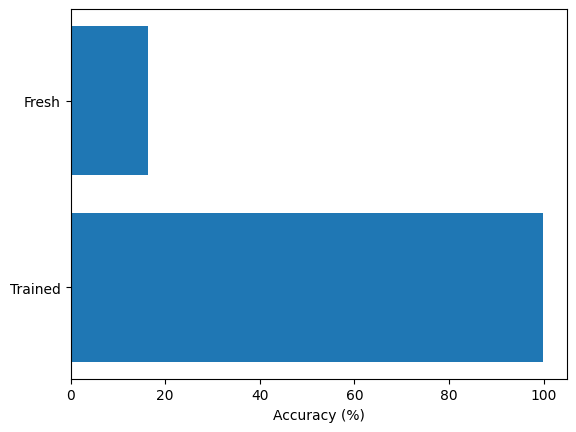

In [18]:
accuracy_trained = eval_stats_trained['avg_acc'].item() * 100
accuracy_fresh = eval_stats_fresh['avg_acc'].item() * 100
print("Test accuracy trained: ", accuracy_trained)
print("Test accuracy fresh: ", accuracy_fresh)

plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.savefig("../../reports/dwsnets-big-accuracy.pdf")
plt.show()